<a href="https://colab.research.google.com/github/DevKor-Team/MRDC-Challenge/blob/jo/jo/Transfer_Learning_with_6_Channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# 이미지 압축 해제
!unzip -q /content/gdrive/MyDrive/ML/MRDC-competition/data/Images.zip -d /content/gdrive/MyDrive/ML/MRDC-competition/data/images

replace /content/gdrive/MyDrive/ML/MRDC-competition/data/images/id_004wknd7qd.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/gdrive/MyDrive/ML/MRDC-competition/data/images/id_004wknd7qd_rgn.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [26]:
from PIL import Image

import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import itertools    # confusion matrix에서 사용

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models

In [ ]:
BASE_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data'

import os

train = pd.read_csv(os.path.join(BASE_DIR, 'Train.csv'))
print(train.shape)
train.head()

(5340, 2)


,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


In [ ]:
train_rgb = train.loc[~train['Image_id'].str.contains('_rgn')]
train_rgb.head()

,Image_id,Label
0,id_004wknd7qd.jpg,blast
2,id_005sitfgr2.jpg,brown
4,id_00stp9t6m6.jpg,blast
6,id_012zxewnhx.jpg,blast
8,id_0186qwq2at.jpg,healthy


In [ ]:
test = pd.read_csv(os.path.join(BASE_DIR, 'Test.csv'))
test_rgb = test.loc[~test['Image_id'].str.contains('_rgn')]
test_rgb.head()

,Image_id
0,id_00vl5wvxq3.jpg
2,id_01hu05mtch.jpg
4,id_030ln10ewn.jpg
6,id_03z57m8xht.jpg
8,id_04ngep1w4b.jpg


In [ ]:
ss = pd.read_csv(os.path.join(BASE_DIR, 'SampleSubmission.csv'))
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.0,0.0,0.0
1,id_01hu05mtch.jpg,0.0,0.0,0.0
2,id_030ln10ewn.jpg,0.0,0.0,0.0
3,id_03z57m8xht.jpg,0.0,0.0,0.0
4,id_04ngep1w4b.jpg,0.0,0.0,0.0


In [ ]:
#@title
IMG_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data/images'
img_path_ = os.path.join(IMG_DIR, train.iloc[0]['Image_id'])
img_path_rgn_ = os.path.join(IMG_DIR, train.iloc[0]['Image_id'].replace('.jpg', '_rgn.jpg'))
img_ = np.array(Image.open(img_path_))
img_rgn_ = np.array(Image.open(img_path_rgn_))

In [ ]:
#@title
img_t = transform(img_)
img_rgn_t = transform(img_rgn_)

In [ ]:
#@title
print(img_t.shape)
print(img_rgn_t.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
#@title
img_concat_ = torch.cat([img_t, img_rgn_t], dim=0)

In [ ]:
#@title
img_concat_.shape

torch.Size([6, 224, 224])

In [ ]:
class Img_Dataset(Dataset):
  def __init__(self, file_path, transform, table, is_train=True):
    # super().__init__()
    self.file_path = file_path
    self.transform = transform
    self.table = table
    self.is_train = is_train
  
  def __len__(self):
    return len(self.table)
  
  def __getitem__(self, index):
    img_name = self.table.iloc[index]['Image_id']
    img_path = os.path.join(self.file_path, img_name)
    img_path_rgn = os.path.join(self.file_path, img_name.replace('.jpg', '_rgn.jpg'))
    img = Image.open(img_path)
    img_rgn = Image.open(img_path_rgn)
    img_transformed = self.transform(img)
    img_rgn_transformed = self.transform(img_rgn)
    img_concat = torch.cat([img_transformed, img_rgn_transformed], dim=0)
    if self.is_train:  # label 붙이기
      if self.table.iloc[index]['Label'] == 'blast':
        # y = [1, 0, 0]
        y = 0
      elif self.table.iloc[index]['Label'] == 'brown':
        # y = [0, 1, 0]
        y = 1
      elif self.table.iloc[index]['Label'] == 'healthy':
        # y = [0, 0, 1]
        y = 2
      # return img_concat, torch.FloatTensor(y)
      return img_concat, y
    else:
      return img_concat


In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [45]:
def make_data_loader(batch_size=128, split=0.8):
  IMG_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data/images'
  transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
  ])

  # train data
  train_dataset = Img_Dataset(IMG_DIR, transform, train_rgb)

  train_size = int(len(train_dataset) * split)
  val_size = len(train_dataset) - train_size

  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
  # whole_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  
  # test data
  test_dataset = Img_Dataset(IMG_DIR, transform, test_rgb, is_train=False)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
  
  return train_loader, val_loader, test_loader

In [ ]:
def train_model(device, model, train_loader, val_loader, criterion, optimizer, num_epochs=5, early_stopping=None):
    model = model.to(device)

    dl = {'train': train_loader,
          'val': val_loader}
    
    val_label = []
    val_pred = []

    val_loss = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dl[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients -> backward시 필요
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    # print(preds)
                    # print(labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    if phase == 'val' and epoch == num_epochs - 1:
                        val_label += labels.tolist()
                        val_pred += preds.tolist()

                # statistics
                running_loss += loss.item() * inputs.size(0)  # size(0) : batch size (첫 번째 차원 개수)
                                                              # item() : tensor에서 저장된 값만 가져오기
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dl[phase].dataset)  # 이렇게 나누면 epoch당 평균 loss가 됨
            epoch_acc = running_corrects.double() / len(dl[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            val_loss = epoch_loss

        if early_stopping != None:
          early_stopping(val_loss, model) # epoch_loss에는 validation loss가 저장
          if early_stopping.early_stop:
            print("Early stopping")
            break

    # load best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return model, val_label, val_pred

In [ ]:
# model의 parameter를 freeze
def set_parameter_requires_grad(model):
      for param in model.parameters():
          param.requires_grad = False

In [ ]:
def initialize_model(num_classes):
  # Use ResNet50
  model_ft = models.resnet50(weights="IMAGENET1K_V2")
  set_parameter_requires_grad(model_ft)
  # 첫 번째 conv layer 구조 변경
  prev_conv_w = model_ft.conv1.weight  # 기존 모델 weight
  model_ft.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  model_ft.conv1.weight = nn.Parameter(torch.cat((prev_conv_w, torch.zeros(64, 3, 7, 7)), dim=1))  # 초기 3-dim weight에 3-dim짜리 zero weight를 붙임 
  model_ft.conv1.requires_grad = True
  # 마지막 output layer 구조 변경
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, num_classes)

  print("Params to learn:")
  params_to_update = []
  for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print("\t",name)

  return model_ft, params_to_update

In [ ]:
# confusion matrix 시각화
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names=None, labels=True):
    accuracy = np.trace(cm) / float(np.sum(cm))

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    thresh = cm.max() / 2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [49]:
def test_model(device, model, test_loader):
  test_pred = []

  model.eval()
  with torch.set_grad_enabled(False):
      for features in test_loader:
          features = features.to(device)

          outputs = model(features.to(torch.float))

          # _, predicted = torch.max(outputs.cpu().data, 1)
          # predicted = outputs.cpu().data
          probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
          # print(probabilities)

          test_pred.append(probabilities.tolist())
          # print(test_pred)
  return test_pred

In [ ]:
resnet, params_to_update = initialize_model(3)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Params to learn:
	 conv1.weight
	 fc.weight
	 fc.bias
ResNet(
  (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
      

In [46]:
# train
train_loader, val_loader, test_loader = make_data_loader()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path="resnet2_checkpoint.pt")

In [ ]:
resnet_tf, val_label, val_pred = train_model(device, resnet, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 0.9340 Acc: 0.5627
val Loss: 0.9298 Acc: 0.5468
Validation loss decreased (inf --> 0.929826).  Saving model ...
Epoch 2/30
----------
train Loss: 0.8984 Acc: 0.5660
val Loss: 0.8917 Acc: 0.5599
Validation loss decreased (0.929826 --> 0.891723).  Saving model ...
Epoch 3/30
----------
train Loss: 0.8646 Acc: 0.5758
val Loss: 0.8614 Acc: 0.5749
Validation loss decreased (0.891723 --> 0.861404).  Saving model ...
Epoch 4/30
----------
train Loss: 0.8374 Acc: 0.5918
val Loss: 0.8355 Acc: 0.5936
Validation loss decreased (0.861404 --> 0.835523).  Saving model ...
Epoch 5/30
----------
train Loss: 0.8125 Acc: 0.6180
val Loss: 0.8104 Acc: 0.6330
Validation loss decreased (0.835523 --> 0.810387).  Saving model ...
Epoch 6/30
----------
train Loss: 0.7939 Acc: 0.6475
val Loss: 0.7918 Acc: 0.6610
Validation loss decreased (0.810387 --> 0.791823).  Saving model ...
Epoch 7/30
----------
train Loss: 0.7709 Acc: 0.6807
val Loss: 0.7692 Acc: 0.6966
Validation loss d

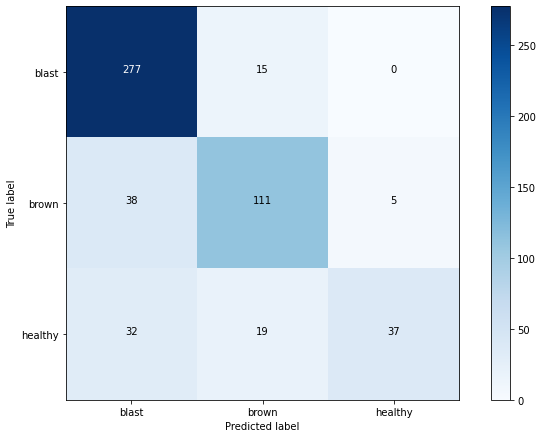

In [ ]:
classes = ['blast', 'brown', 'healthy']
plot_confusion_matrix(confusion_matrix(val_label, val_pred), target_names=classes)

In [28]:
# inference
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'resnet1_checkpoint.pt'), map_location=torch.device('cpu')))

In [47]:
len(test_loader)

1145

In [50]:
test_pred = test_model(device, resnet, test_loader)

In [51]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_resnet50_1.csv", index=False)
ss.head()

# 예상대로 score는 매우 낮다... 더 학습 필요

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.896373,0.056337,0.047289
1,id_01hu05mtch.jpg,0.496027,0.422156,0.081817
2,id_030ln10ewn.jpg,0.387157,0.398006,0.214838
3,id_03z57m8xht.jpg,0.839404,0.090468,0.070128
4,id_04ngep1w4b.jpg,0.663642,0.147144,0.189214
